# Tensor factorization

With help from:

https://medium.com/yadb/tensor-factorization-for-graph-analysis-in-python-590df44c9f6c

In [69]:
import tensorly as tl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [141]:
# Open bike trips data
df_April = pd.read_csv('Edinburgh/04.csv')
df_April.started_at = pd.to_datetime(df_April.started_at)
df_April.ended_at = pd.to_datetime(df_April.ended_at)
df_April['trip_duration'] = (df_April.ended_at-df_April.started_at).apply(lambda x : x.seconds/60)

In [187]:
import geopandas as gpd
from shapely.geometry import Point

# Extract the bike stations in it

def get_all_stations(df):
    df_start_stations = df[['start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude']]
    df_end_stations = df[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']]
    df_start_stations.columns = ['station_id', 'station_name', 'station_lat', 'station_lon']
    df_end_stations.columns = ['station_id', 'station_name', 'station_lat', 'station_lon']
    return df_start_stations.append(df_end_stations).drop_duplicates().set_index('station_id')

df_stations = get_all_stations(df_April)
df_stations.to_csv('df_stations.csv')
df_stations['geometry'] = df_stations[['station_lat','station_lon']].apply(lambda x : Point(*x), axis=1)
df_stations=gpd.GeoDataFrame(df_stations)

In [189]:
from pyproj import CRS

df_stations.crs = CRS.from_epsg(4326)

In [94]:
df_trips = df_April[['started_at', 'ended_at', 'trip_duration', 'start_station_id', 'end_station_id']].copy()

station_to_ix = {j:i for i,j in enumerate(sorted(df_April.start_station_id.unique()))}
ix_to_station = {j:i for i,j in station_bridge.items()}

df_trips[['start_station_id', 'end_station_id']] = df_trips[['start_station_id', 'end_station_id']].applymap(lambda x : station_to_ix[x])
df_trips['started_floor'] = df_trips.started_at.apply(lambda x:x.floor('15min'))
df_trips['ended_floor'] = df_trips.ended_at.apply(lambda x:x.floor('15min'))

df_trips['weekday'] = df_trips.started_at.apply(lambda x:x.weekday)
df_trips['hour'] = df_trips.started_at.apply(lambda x:x.hour)

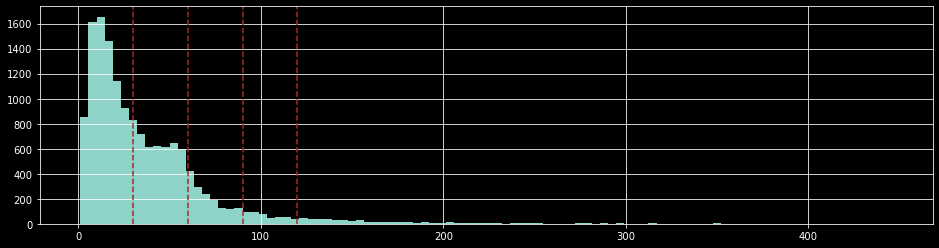

In [71]:
df_trips.trip_duration.hist(bins=100, figsize=(16,4))
plt.axvline(30, color='brown', ls='--')
plt.axvline(60, color='brown', ls='--')
plt.axvline(90, color='brown', ls='--')
plt.axvline(120, color='brown', ls='--')

### Let's try a factorization per hour of the day, to start. 

In [72]:
T = np.zeros((len(df_trips.start_station_id.unique()), len(df_trips.end_station_id.unique()), 24), dtype=float)

for row in df_trips[['hour', 'start_station_id', 'end_station_id']].iterrows():
    T[row[1]['start_station_id'],row[1]['end_station_id'],row[1]['hour']]+=1

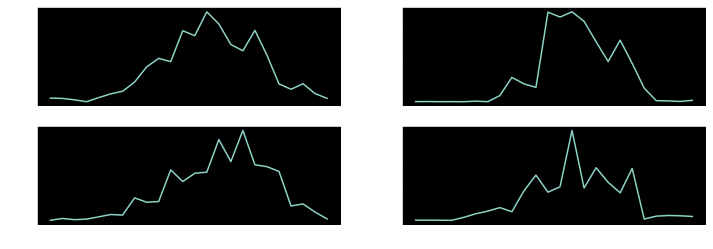

In [73]:
from tensorly.decomposition import non_negative_parafac as NNP

R=4

F=NNP(tensor=T, rank=R, verbose=0)

weights=F[0]
factors=F[1]

Us,Vs,Xs = factors

fig, axes = plt.subplots(2,2, figsize=(12,4))
fig.patch.set_alpha(0)
axes=axes.flatten()

for i in range(R):

    starts = Us[:, i]
    ends = Vs[:, i]
    t_intensity = Xs[:, i]

    axes[i].plot(t_intensity)

plt.show()

### Let's try the core consistency .

C is a negative sum of the reconstruction error. <br>
It is $~ (1 - \frac{\sum \epsilon }{n}$, with $\epsilon$ the reconstruction error (Identity matrix - actual superdiag matrix needed to rebuild T from the factors) : Higher reconstruction error means high |CC| in the negative: we want to maximize both k and CC !

In [6]:
from sktensor import dtensor, cp_als
import imp
import corcondia
imp.reload(corcondia)

In [66]:
mean_CC = lambda x : np.mean([corcondia.corcondia(dtensor(T), components = x) for i in range(5)])

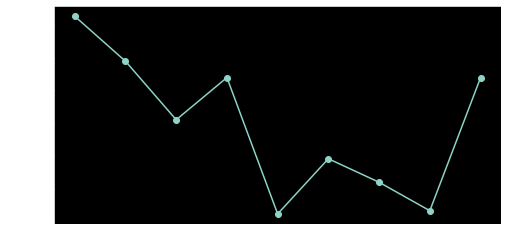

In [67]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(1, 10)
plt.plot(x_range, [mean_CC(R) for R in x_range], marker='o')
plt.show()

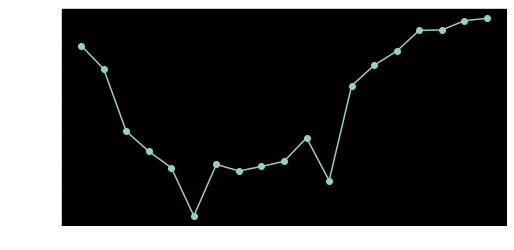

In [68]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(1, 150, 8)
plt.plot(x_range, [mean_CC(R) for R in x_range], marker='o')
plt.show()

# Map a parallel factor back to the bike stations

In [166]:
i=0
factor = np.outer(Us[:, i], Vs[:, i])

In [175]:
factor_trips = pd.DataFrame(columns=['start', 'end', 'intensity'], index=range(97**2))

for i,u in enumerate(factor):
    print(i)
    for j,v in enumerate(u):
        factor_trips.loc[i*97 + j] = [i,j,v]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [181]:
factor_trips['start_station_id'] = factor_trips.start.apply(lambda x : ix_to_station[x])
factor_trips['end_station_id'] = factor_trips.end.apply(lambda x : ix_to_station[x])

In [185]:
factor_trips.to_csv('factor_trips.csv')

In [186]:
factor_trips

,start,end,intensity,start_station_id,end_station_id
0,0,0,0.06005,171,171
1,0,1,0.187447,171,183
2,0,2,0.022562,171,189
3,0,3,0.03155,171,225
4,0,4,0.057137,171,246
...,...,...,...,...,...
9404,96,92,0.0,2268,1877
9405,96,93,0.049955,2268,2259
9406,96,94,0.081385,2268,2263
9407,96,95,0.031644,2268,2265
